In [3]:
import numpy as np
import datasets
import torch
import pickle

In [63]:
Train = datasets.load_dataset("wmt16","de-en", split="train[:50000]")
Val = datasets.load_dataset("wmt16","de-en", split="validation")
Test = datasets.load_dataset("wmt16","de-en", split="test")

In [64]:
from transformers import AutoTokenizer
src_lang='en'
target_lang='de'
prefix='translate English to German: '
checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [65]:
def preprocess(examples):
    inputs = [prefix + example[src_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=64, truncation=True)
    return model_inputs

In [75]:
dataset_dict_truncated = datasets.DatasetDict({
    'train': datasets.Dataset.from_dict({'translation': Train['translation']}),
    'validation': datasets.Dataset.from_dict({'translation': Val['translation']}),
    'test': datasets.Dataset.from_dict({'translation': Test['translation']})
})

In [67]:
tokenized_dataset = dataset_dict_truncated.map(preprocess, batched=True)

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [68]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [69]:
# !pip install transformers datasets evaluate sacrebleu
# !pip install bert-score
# !pip install -U nltk

from evaluate import load

metric = load("bleu")
bertscore = load("bertscore")
meteor_metric = load("meteor")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    bleu_1 = metric.compute(predictions=decoded_preds, references=decoded_labels, max_order=1)['bleu']
    bleu_2 = metric.compute(predictions=decoded_preds, references=decoded_labels, max_order=2)['bleu']
    bleu_3 = metric.compute(predictions=decoded_preds, references=decoded_labels, max_order=3)['bleu']
    bleu_4 = metric.compute(predictions=decoded_preds, references=decoded_labels, max_order=4)['bleu']
    
    meteor_score = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)['meteor']
    bert_score = np.array(bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang=target_lang)['f1']).mean()
#     _, _, bert_score_f1 = bertscore(decoded_preds, decoded_labels, lang='en', verbose=False)


    result = {
        "bleu 1": round(bleu_1, 4),
        "bleu 2": round(bleu_2, 4),
        "bleu 3": round(bleu_3, 4),
        "bleu 4": round(bleu_4, 4),
        "meteor": round(meteor_score, 4),
        "bert_score": bert_score
    }
    return result

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [96]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [107]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=48,
    per_device_eval_batch_size=48,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [72]:
evaluation_result = trainer.predict(tokenized_dataset['test'])


Zero Shot Evaluation result

In [73]:
evaluation_result[-1]

{'test_loss': 0.9922035336494446,
 'test_bleu 1': 0.2914,
 'test_bleu 2': 0.2305,
 'test_bleu 3': 0.1876,
 'test_bleu 4': 0.1551,
 'test_meteor': 0.4038,
 'test_bert_score': 0.8056772429571822,
 'test_runtime': 58.7112,
 'test_samples_per_second': 51.081,
 'test_steps_per_second': 0.204}

Freeze all Layers except Final

In [103]:
src_lang='de'
target_lang='en'
prefix='translate German to English: '

def preprocess2(examples):
    inputs = [prefix + example[src_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=64, truncation=True)
    return model_inputs

tokenized_dataset = dataset_dict_truncated.map(preprocess2, batched=True)

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [100]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [108]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Bleu 1,Bleu 2,Bleu 3,Bleu 4,Meteor,Bert Score
1,1.742500,1.721297,0.326100,0.232100,0.172500,0.131600,0.394400,0.908310
2,1.476900,1.737149,0.328200,0.233700,0.173500,0.132200,0.398600,0.909558
3,1.301200,1.766583,0.331300,0.236700,0.176600,0.135000,0.402400,0.910470
4,1.165700,1.812144,0.332900,0.238300,0.178400,0.137200,0.404100,0.911123
5,1.069400,1.857038,0.331200,0.236800,0.176900,0.135900,0.403200,0.910943


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors we

In [110]:
train_losses = [1.742500, 1.476900, 1.301200, 1.165700, 1.069400]
val_losses = [1.857038, 1.812144, 1.766583, 1.737149, 1.721297]

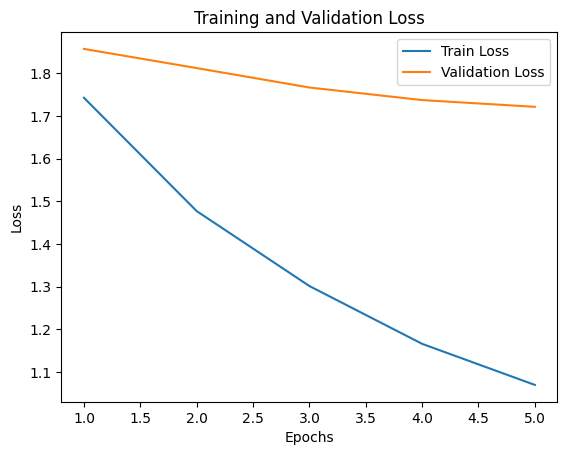

In [113]:
from matplotlib import pyplot as plt

epochs = np.arange(1, 6)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Eval post Finetuning

In [109]:
evaluation_result = trainer.predict(tokenized_dataset['test'])
evaluation_result[-1]

{'test_loss': 1.6791006326675415,
 'test_bleu 1': 0.3511,
 'test_bleu 2': 0.255,
 'test_bleu 3': 0.192,
 'test_bleu 4': 0.1472,
 'test_meteor': 0.4275,
 'test_bert_score': 0.9118926538829606,
 'test_runtime': 78.9938,
 'test_samples_per_second': 37.965,
 'test_steps_per_second': 0.405}